<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v1)
In this first initial network, we create a simple UNet that attempts to reconstruct the occupancy-map from LDS data in 2D coordinates.

We'll be using our single low-res simple floorplan and just create a bunch of samples from it for training data.

In [151]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git pull
else:
  !git clone https://github.com/malcolmlett/robovac.git repo
from repo import lds
from importlib import reload
reload(lds)

HEAD is now at dc0beba Works now
Updating dc0beba..afbab9b
Fast-forward
 lds.py                         |  25 ++++++++++++++++---------
 misc/images/640px-Tiger.50.jpg | Bin 0 -> 66484 bytes
 2 files changed, 16 insertions(+), 9 deletions(-)
 create mode 100644 misc/images/640px-Tiger.50.jpg


<module 'repo.lds' from '/content/repo/lds.py'>

In [2]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [175]:
# Load our simple low-res black'n'white floorplan
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Training data generation
We'll create training data by generating a bunch of samples from the floorplan.

For each attempted sample:
1. pick a random location and orientation on the map
1. take a sample
1. discard if the ranges all end up within the radius of a single pixel (ie: our random chosen location was inside a wall)
1. generate a zeroed-out max_distance x max_distance semantic map, centered on the chosen location
1. populate a True/1 into the nearest-neighbour pixel corresponding to each LDS hit.
1. that becomes the training X data
1. separately, take a max_distance x max_distance square snapshot of the floorplan, centred on the chosen location.
1. apply a mask that zeros-out the corners - anything beyond the max_distance radius from the centre
1. that becomes the training Y labels


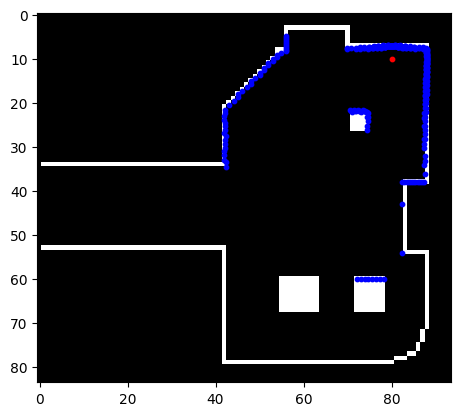

In [176]:
pixel_size = 6.8  # cm
max_distance = 350 # cm
loc = np.array([80.0, 10.0]) * pixel_size
#loc = (80, 10)
ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance)
points = lds.lds_to_2d(ranges, loc, 0.0)
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0]/pixel_size, loc[1]/pixel_size, c='r', s=10)
plt.scatter(points[:,0]/pixel_size, points[:,1]/pixel_size, c='b', s=10)

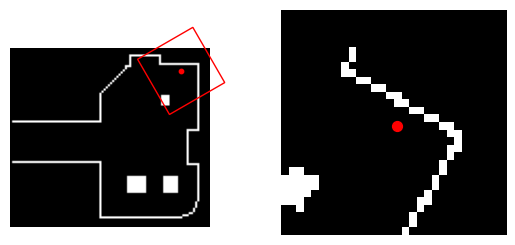

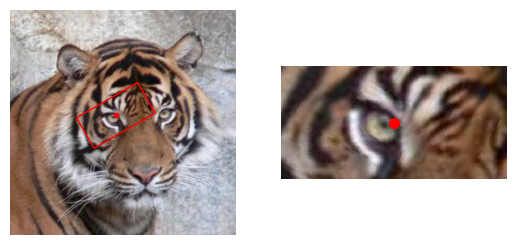

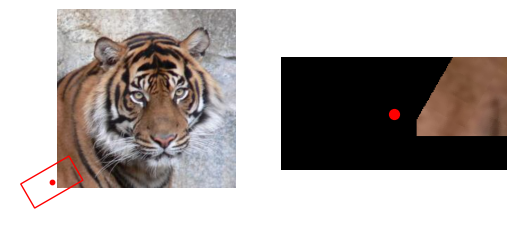

In [191]:
def rotated_crop(image, centre, angle, size):
  """
  Takes a crop of a particular size and angle from any image-like source.
  Fills in any unknown areas with zeros.

  Arguments:
  - image: array (r,c) of bool, uint8, float32, etc.
      The image to take a crop from.
  - centre: [x,y] of float
      Centre of the crop.
  - angle: float
      The angle of the crop in radians, counterclockwise.
  - size: [w,h] of float
      The size of the crop.
  """
  h, w = image.shape[0:2]

  # handle boolean image types
  target_type = image.dtype
  if target_type == 'bool':
    image = image.astype(np.uint8)

  # rotate whole image first about the centre point
  rotation_matrix = cv2.getRotationMatrix2D(centre, -np.rad2deg(angle), scale=1.0)
  rotated = cv2.warpAffine(image, rotation_matrix, (w,h), flags=cv2.INTER_NEAREST)
  if target_type == 'bool':
    rotated = rotated.astype(bool)

  # take crop around the centre point
  zero_value = True if image.dtype == 'bool' else 0 if np.issubdtype(image.dtype, np.integer) else 0.0
  crop_shape = np.array(image.shape)
  crop_shape[0] = size[1]
  crop_shape[1] = size[0]
  cropped = np.full(crop_shape, zero_value, dtype=image.dtype)

  x1 = max(0, int(centre[0] - size[0]/2))
  x2 = min(w, int(centre[0] - size[0]/2) + size[0])
  y1 = max(0, int(centre[1] - size[1]/2))
  y2 = min(h, int(centre[1] - size[1]/2) + size[1])

  start_x = max(0, -int(centre[0] - size[0]/2))
  start_y = max(0, -int(centre[1] - size[1]/2))
  cropped[start_y:start_y + (y2-y1), start_x:start_x + (x2-x1), ...] = rotated[y1:y2, x1:x2, ...]

  return cropped

def rotated_crop_test(image, loc, size, angle):
  crop = rotated_crop(image, loc, np.deg2rad(angle), size)

  plt.subplot(1,2,1)
  plt.imshow(image, cmap='gray')
  plt.scatter(loc[0], loc[1], c='r', s=10)
  plt.gca().add_patch(plt.Rectangle((loc[0]-size[0]/2,loc[1]-size[1]/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(crop, cmap='gray')
  plt.scatter(crop.shape[1]/2, crop.shape[0]/2, c='r', s=50)
  plt.axis('off')
  plt.show()

tiger = cv2.imread('repo/misc/images/640px-Tiger.50.jpg')
tiger = cv2.cvtColor(tiger, cv2.COLOR_BGR2RGB)

rotated_crop_test(floorplan, loc=(80,10), size=(30,30), angle=30)
rotated_crop_test(tiger, loc=(300,300), size=(200,100), angle=30)
rotated_crop_test(tiger, loc=(-20,620), size=(200,100), angle=30)

In [178]:
np.array([1,2,3,4,5,6,7,8]).reshape([2,4]).shape

(2, 4)

In [182]:
s = np.array([1,2,3,4,5,6,7,8]).reshape([2,2,2])
print(f"shape: {s.shape}")
s[1]

shape: (2, 2, 2)


array([[5, 6],
       [7, 8]])

values: nothing=False, occupated=True
ranges: 19.877149321618795-344.3240707005354
semantic_map: (84, 94), lds_points: (330, 2), size_px: 105
points(lds.rel): (-139.80863628489513,-49.44438878155861)-(232.06188676354566,298.91952526045924)
points(px.abs): (31,45)-(86,96)


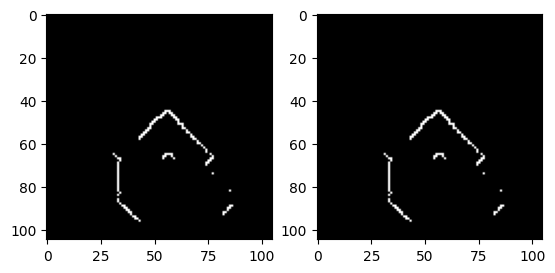

In [45]:
def generate_training_data_sample(semantic_map, centre, angle, **kwargs):
    """
    Generates a single training sample from the semantic map.
    Returns (None,None) if the sample is meaningless, which can occur when
    the specified centere is within the bounds of the pixels (all LDS ranges have value ~0.0),
    or if there are no LDS hits (all LDS ranges are NaN).

    Parameters:
    - semantic_map: array (r,c) of bool or float
        Encoded as a 2D array of values.
    - centre: [x,y] of float
        Point from which LDS sample is taken (unit: physical units)
    - angle: float
        Starting angle of LDS sample (unit: radians)

    Keyword args:
    - max_distance: float, default: 100
        Maximum distance that an LDS can observe (unit: physical units)
    - pixel_size: float, default: 1.0.
        The size of the pixel in the desired physical unit.
        Defaults to 1.0, meaning that we output in pixel units.
    - nothing_value: bool or float, default: min value from semantic_map
        The data value that indicates nothing is present at the pixel.
        All other values are treated as pixels.
    - occupated_value: bool or float, default: max value from semantic_map
        The data value used by LDS hits.

    Returns:
    (lds_map, ground_truth_map), where:
      - lds_map: array (r,c) of bool or flat
          Square max_distance x max_distance semantic map populated from LDS data alone.
      - ground_truth_map: array (r,c) of bool or flat
          Square max_distance x max_distance masked snapshot from ground truth source semantic map.
    """
    # config
    max_distance = kwargs.get('max_distance', 100)
    pixel_size = kwargs.get('pixel_size', 1.0)
    nothing_value = kwargs.get('nothing_value', np.min(semantic_map))
    occupated_value = kwargs.get('occupated_value', np.max(semantic_map))
    print(f"values: nothing={nothing_value}, occupated={occupated_value}")

    # take sample
    ranges = lds.lds_sample(semantic_map, centre, angle, max_distance=max_distance, pixel_size=pixel_size, nothing_value=nothing_value)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None
    print(f"ranges: {np.nanmin(ranges)}-{np.nanmax(ranges)}")

    # generate LDS semantic map
    # (note: from LDS data alone we don't know absolute centre or orientation, so we work relative to origin here)
    lds_points = lds.lds_to_2d(ranges, (0,0), 0.0)
    #print(lds_points.astype(str))
    size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1  # odd numbered, with equivalent of max_distance out from centre pixel
    lds_points_px = np.round(lds_points / pixel_size + (size_px-1)/2).astype(int)
    #print(f"semantic_map: {semantic_map.shape}, lds_points: {lds_points.shape}, size_px: {size_px}")
    #print(f"points(lds.rel): ({np.min(lds_points[:,0])},{np.min(lds_points[:,1])})-({np.max(lds_points[:,0])},{np.max(lds_points[:,1])})")
    #print(f"points(px.abs): ({np.min(lds_points_px[:,0])},{np.min(lds_points_px[:,1])})-({np.max(lds_points_px[:,0])},{np.max(lds_points_px[:,1])})")
    lds_map = np.full((size_px, size_px), nothing_value, dtype=semantic_map.dtype)
    lds_map[lds_points_px[:,1], lds_points_px[:,0]] = occupated_value

    # generate ground truth map
    # (here we know the centre and orientation, but we have to translate it to the same location and orientation as used by the LDS map)
    from_row =
    ground_truth_map = semantic_map[]


    return (lds_map, None)

def generate_training_data_sample_test():
  pixel_size=6.8
  max_distance=350
  loc = np.array([80.0, 10.0]) * pixel_size
  angle = np.deg2rad(45)
  (lds_map, truth_map) = generate_training_data_sample(floorplan, loc, angle, max_distance=max_distance, pixel_size=pixel_size)
  plt.subplot(1,2,1)
  plt.imshow(lds_map, cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(lds_map, cmap='gray')
  plt.show()

generate_training_data_sample_test()

In [9]:
floorplan.dtype

dtype('bool')

In [ ]:
def generate_training_data(semantic_map, num_samples, **kwargs):
    """
    Generates training data sampled from the semantic map.
    Each training data X item contains:
    - 2d-array (r,c) raw semantic_map from LDS data alone
    Each training data Y item contains:
    - 2d-array (r,c) expected semantic_map
    """
    max_distance = kwargs.get('max_distance', 100)
    step_size = kwargs.get('step_size', max_distance/3)
    nothing_value = kwargs.get('nothing_value', 0.0)
    pixel_size = kwargs.get('pixel_size', 1.0)

  #max_distance =

## Appendix: OpenCV
In the above we needed to use OpenCV to work with images.
Here's some experiments.

image: (640, 640, 3), uint8


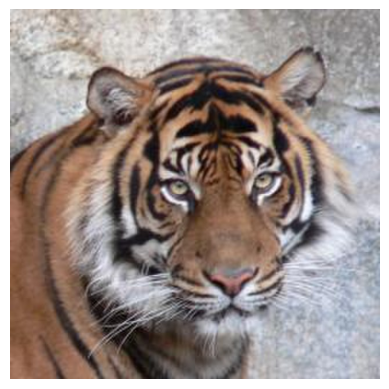

In [101]:
# get image
image = cv2.imread('repo/misc/images/640px-Tiger.50.jpg')

print(f"image: {image.shape}, {image.dtype}")

# convert to RGB and show
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

rotation_matrix: [[  0.7878462    0.13891854 135.77843046]
 [ -0.13891854   0.7878462   88.90786697]]


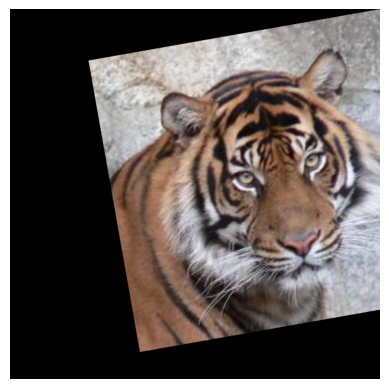

In [100]:
rotation_matrix = cv2.getRotationMatrix2D((640,0), 10, scale=0.8)
print(f"rotation_matrix: {rotation_matrix}")
rotated = cv2.warpAffine(image, rotation_matrix, (640,640))

plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

rotation_matrix: [[   0.70710678    0.70710678 -444.26406871]
 [  -0.70710678    0.70710678  167.45166004]]


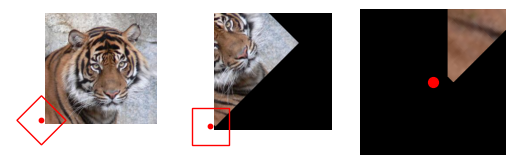

In [149]:
def experimental_take_rotated_crop(image, centre, angle, size):
  h, w, _ = image.shape

  # rotate whole image first about the centre point
  rotation_matrix = cv2.getRotationMatrix2D(centre, angle, scale=1.0)
  print(f"rotation_matrix: {rotation_matrix}")
  rotated = cv2.warpAffine(image, rotation_matrix, (w,h), flags=cv2.INTER_NEAREST)

  # take crop around the centre point
  zero_value = True if image.dtype == 'bool' else 0 if np.issubdtype(image.dtype, np.integer) else 0.0
  crop_shape = np.array(image.shape)
  crop_shape[0] = size[1]
  crop_shape[1] = size[0]
  cropped = np.full(crop_shape, zero_value, dtype=image.dtype)

  x1 = max(0, int(centre[0] - size[0]/2))
  x2 = min(w, int(centre[0] - size[0]/2) + size[0])
  y1 = max(0, int(centre[1] - size[1]/2))
  y2 = min(h, int(centre[1] - size[1]/2) + size[1])

  start_x = max(0, -int(centre[0] - size[0]/2))
  start_y = max(0, -int(centre[1] - size[1]/2))
  cropped[start_y:start_y + (y2-y1), start_x:start_x + (x2-x1), :] = rotated[y1:y2, x1:x2, :]

  return (rotated,cropped)

loc = (-20,620)
size = (200,200)
angle = 45
(rotated, crop) = experimental_take_rotated_crop(image, loc, angle, size)

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-size[0]/2,loc[1]-size[1]/2), size[0], size[1], angle=angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-size[0]/2,loc[1]-size[1]/2), size[0], size[1], linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.scatter(crop.shape[1]/2, crop.shape[0]/2, c='r', s=50)
plt.axis('off')
plt.show()

In [128]:
floorplan.dtype

dtype('bool')

In [130]:
image.dtype == 'bool'

False

In [58]:
type(image)

numpy.ndarray